In [55]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import EmbeddingFunction
from transformers import AutoTokenizer, AutoModel


load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

CHROMA_DB_DIR = "./chroma_db"
COLLECTION_NAME = "schema_embeddings"
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

Base = declarative_base()


# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## Functions for Agent

In [61]:
import os
from typing import List, Optional
from chromadb import PersistentClient
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
import json
from langchain_core.prompts.chat import SystemMessage, HumanMessage
# Load environment variables
load_dotenv()

# Define the path to the ChromaDB directory
CHROMA_DB_DIR = os.getenv("CHROMA_DB_DIR", "chromadb")

class AgentState(TypedDict):
    question: str
    sql_query: Optional[str]
    query_result: Optional[str]
    query_rows: List[dict]
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool
    context: List[str]
    chart_type: Optional[str]
    chart_title: Optional[str]
    schema_info: str
    database_description: str
    

MAX_RETRIES = 3



def get_database_schema(state: AgentState, config: dict) -> AgentState:
    """
    Extracts relevant schema information and generates a database description.
    """
    print("[DEBUG] Retrieving database schema...")

    question = state["question"]

    # Retrieve relevant schema context using hybrid search
    context = hybrid_search(
        question,
        schema,  # Extracted database schema
        chroma_collection,
        embedding_model,
        graph,
        max_results=15
    )

    if not context:
        print("[DEBUG] No relevant schema found.")
        state["schema_info"] = ""
        state["database_description"] = ""
        return state

    # Extract schema information for relevant tables
    schema_info = ["### Relevant Schema Information"]
    relevant_tables = set()
    table_summaries = []

    for node in context:
        try:
            node_type = graph.nodes[node]["type"]
            if node_type == "table":
                relevant_tables.add(node)
            elif node_type == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue

    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})

        schema_info.append(f"\nTable: {table}")
        if primary_keys:
            schema_info.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            schema_info.append(f"  - Examples: {examples}")

        # Summarize the table for database description
        summary = f"Table '{table}' contains {len(graph[table])} columns."
        if primary_keys:
            summary += f" It has primary key(s): {', '.join(primary_keys)}."
        if examples:
            summary += f" Example values: {', '.join(map(str, list(examples.values())[:3]))}."
        table_summaries.append(summary)

    # Generate database description using LLM
    system_prompt = f"""
    You are an expert in database systems. Given the extracted schema information below,
    provide a concise and informative 5-6 sentence description of the database.
    
    **Extracted Schema Information:**
    {'. '.join(table_summaries)}

    The description should be clear, mentioning the key tables, their purpose, and how they relate to each other.
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    database_description = response.content.strip()

    # Store schema info and database description in state
    state["schema_info"] = "\n".join(schema_info)
    state["database_description"] = database_description

    print(f"[DEBUG] Generated database description: {state['database_description']}")

    # ✅ Return the updated state instead of a function reference
    return state



class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI



class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

# Convert Natural Language to SQL

def convert_nl_to_sql(state: AgentState):
    """
    Convert user question into an SQL query using extracted schema.
    """
    question = state["question"]
    schema_info = state.get("schema_info", "")
    data_description = state.get("database_description", "")

    if not schema_info:
        state["sql_query"] = ""
        print("[DEBUG] No schema info available.")
        return state

    system_prompt = f"""
    Convert the question into an SQL query using this schema:

    Question: {question}
    Database Schema: {schema_info}
    Database Description: {data_description}
    user_id: {state.get("current_user_id", "None")}
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    response_content = response.content.strip()

    # Debugging
    print("Raw LLM Response Content:", response_content)

    # Remove SQL formatting artifacts
    if response_content.startswith("```sql") and response_content.endswith("```"):
        response_content = response_content[6:-3].strip()

    print("Cleaned LLM Response Content:", response_content)
    
    # Store SQL query in state
    state["sql_query"] = response_content
    return state


from sqlalchemy.exc import SQLAlchemyError, OperationalError

def execute_sql(state: AgentState) -> AgentState:
    """Execute SQL query with safety checks and robust error handling."""
    print("[DEBUG] Executing SQL query...")

    session = SessionLocal()
    state["sql_error"] = False
    state["query_rows"] = []
    
    try:
        sql_query = state.get("sql_query", "").strip()
        if not sql_query:
            raise ValueError("No SQL query provided.")
        if not sql_query.lower().startswith("select"):
            raise ValueError("Only SELECT queries are allowed.")

        # Execute query securely
        result = session.execute(text(sql_query))

        # Fetch column names and results
        columns = result.keys()
        rows = [dict(zip(columns, row)) for row in result.scalars().all()]  # ✅ Performance boost

        # Update state with query results
        state.update({
            "query_rows": rows,
            "query_result": f"Retrieved {len(rows)} records."
        })

    except OperationalError as e:
        state.update({
            "sql_error": True,
            "query_result": f"Database connection error: {str(e)}"
        })
    except SQLAlchemyError as e:
        state.update({
            "sql_error": True,
            "query_result": f"SQL execution error: {str(e)}"
        })
    except Exception as e:
        state.update({
            "sql_error": True,
            "query_result": f"Unexpected error: {str(e)}"
        })
    finally:
        session.close()

    print(f"[DEBUG] SQL Execution Completed - {state['query_result']}")
    return state



def regenerate_query(state: AgentState):
    """
    Reformulates the user's question to make it SQL-compatible based on database schema,
    previous SQL errors, and LLM-driven refinement.
    """
    if state["attempts"] >= MAX_RETRIES:
        state["query_result"] = "Max retries reached. Unable to process your request."
        state["sql_query"] = None  # Prevent further execution
        return state

    question = state["question"]
    database_description = state.get("database_description", "No database description available.")
    schema_info = state.get("schema_info", "No schema info available.")
    previous_sql_error = state.get("query_result", "")

    # Generate a structured prompt to reformulate the question
    system_prompt = f"""
    You are an expert in SQL and database systems. Your task is to refine the following natural language question
    to ensure it is clear, precise, and SQL-compatible.

    **Database Context:**
    {database_description}

    **Schema Details:**
    {schema_info}

    **User's Original Question:**
    "{question}"

    **Previous SQL Issue (if any):**
    {previous_sql_error}

    Please reformulate the question while keeping the original intent, ensuring it is properly structured
    for conversion into a valid SQL query. The output should be **only** the refined question, without any explanations.
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
    )

    response = llm([SystemMessage(content=system_prompt)])
    refined_question = response.content.strip()

    # Store the refined question and update attempts
    state["question"] = refined_question
    state["attempts"] += 1

    print(f"[DEBUG] Refined Question (Attempt {state['attempts']}): {refined_question}")

    return state




def generate_human_readable_answer(state: AgentState) -> AgentState:
    """Generate a natural language response using LLM for query explanation and context."""
    print("[DEBUG] Generating human-readable answer with LLM")

    components = {
        "user": state.get("current_user", "User"),
        "error": state.get("sql_error", False),
        "result": state.get("query_result", ""),
        "rows": state.get("query_rows", []),
        "chart_type": state.get("chart_type"),
        "chart_title": state.get("chart_title"),
        "sql_query": state.get("sql_query", ""),
        "database_description": state.get("database_description", "This database contains structured information relevant to your queries.")
    }

    # Define base message
    base_message = f"Hello {components['user']}, "

    # Error Handling
    if components["error"]:
        error_message = (
            f"there was an error executing your query.\n\n"
            f"🔴 **Error Details:** {components['result']}\n\n"
            "Possible reasons:\n"
            "- The table or column you requested might not exist.\n"
            "- There could be a syntax issue in the generated SQL query.\n"
            "- Database connectivity issues.\n\n"
            "📌 Try rephrasing your question or ensuring the data exists."
        )
        state["query_result"] = base_message + error_message
        return state

    # LLM Prompt to Generate Natural Language Response
    system_prompt = f"""
    You are an expert data analyst. Your task is to explain the results of a SQL query to a user in simple, insightful, and informative language.
    
    ** User's question:**
    {state['question']}
    
    **Database Context:**  
    {components['database_description']}
    
    **SQL Query Executed:**  
    ```sql
    {components['sql_query']}
    ```

    **Query Execution Result:**  
    {components['result']}

    **Scenario Handling:**  
    - If the query returned a dataset, provide a **summary of the results**, highlight key findings, and mention potential insights.  
    - If a chart was generated, explain what it represents and its significance.  
    - If no data was found, suggest possible reasons and alternative queries.  
    - Avoid using overly technical SQL terms—keep it user-friendly.

    **User-Friendly Response Format:**  
    - Start with a **greeting and summary**.  
    - Provide an **overview of the query results**.  
    - Offer **insights or trends** based on the data.  
    - End with a **call to action or next steps**.
    """

    # Human input message (contextualizing response)
    human_message = f"Here is the retrieved data: {components['rows'][:5] if components['rows'] else 'No data found'}"

    # LLM API Call with error handling
    try:
        llm = AzureChatOpenAI(
            temperature=0.5,
            azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
            openai_api_version=os.getenv("OPENAI_API_VERSION"),
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
        )
        response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=human_message)])
        
        # Clean and validate LLM response
        response_content = response.content.strip()
        if response_content.startswith("```") and response_content.endswith("```"):
            response_content = response_content[3:-3].strip()  # Remove markdown code blocks
        
        state["query_result"] = response_content
    except Exception as e:
        state["query_result"] = f"Error generating human-readable explanation: {str(e)}"

    print("[DEBUG] Generated Human-Readable Explanation:", state["query_result"])
    return state


class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")



def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = AzureChatOpenAI(
        temperature=0.8,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    relevance = state.get("relevance", "").lower()
    if relevance == "relevant":
        return "retrieve_context" 
    else:
        return "generate_funny_response"


def check_attempts_router(state: AgentState):
    attempts = state.get("attempts", 0)
    if attempts < 10:
        return "convert_nl_to_sql"
    else:
        return "end_max_iterations"


def execute_sql_router(state: AgentState):
    if state.get("sql_query") is None or state.get("sql_error", False):
        if state["attempts"] >= MAX_RETRIES:
            return "end_max_iterations"
        return "regenerate_query"
    elif state.get("query_rows"):
        return "generate_visualization"
    else:
        return "generate_human_readable_answer"


    
def merge_question_updates(state):
    """
    Consolidates updates to the 'question' key.
    """
    state["merged_question"] = state.get("question", "")
    return state







In [4]:
from typing import Dict, List
import torch



class ThaiBGEEmbeddingFunction(EmbeddingFunction):
    """
    Embedding function with proper pooling and Thai language support
    """
    def __init__(self, model_name= "BAAI/bge-m3"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Disable dropout for evaluation

    def __call__(self, texts: List[str]) -> List[List[float]]:
        """
        Generate embeddings for input texts
        Args:
            texts (List[str]): List of strings to embed
        Returns:
            List[List[float]]: List of embeddings
        """
        if isinstance(texts, str):  # Ensure input is a list
            texts = [texts]
        
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]  # CLS pooling
        return embeddings.cpu().numpy().tolist()

def process_schema_to_graph_and_embeddings(schema: Dict, chroma_collection, embedding_model) -> nx.DiGraph:
    """
    Process database schema into a graph structure and store embeddings in ChromaDB,
    using M-Schema format for enhanced metadata.
    """
    graph = nx.DiGraph()
    entries = []

    for table_name, details in schema.items():
        # Add table as a node with enriched metadata
        graph.add_node(
            table_name,
            type="table",
            description=details.get("description", ""),
            primary_keys=details.get("primary_keys", []),
            examples=details.get("examples", {})
        )

        # Process columns with M-Schema metadata
        for column in details["columns"]:
            column_id = f"{table_name}.{column['name']}"
            
            # Safely get examples for the column and serialize them
            examples = column.get("examples", [])
            examples_serialized = ", ".join(map(str, examples)) if examples else "None"
            
            graph.add_node(
                column_id,
                type="column",
                table=table_name,
                data_type=column["type"],
                primary_key=column.get("primary_key", False),
                examples=examples_serialized  # Store serialized examples
            )
            graph.add_edge(table_name, column_id, relation="has_column")

            # Add column embedding entry
            column_text = (
                f"Column: {column['name']} ({column['type']}), "
                f"Primary Key: {column.get('primary_key', False)}, "
                f"Examples: {examples_serialized}"
            )
            embedding = embedding_model([column_text])[0]

            entries.append({
                "id": column_id,
                "text": column_text,
                "embedding": embedding,
                "metadata": {
                    "type": "column",
                    "table": table_name,
                    "data_type": column["type"],
                    "primary_key": column.get("primary_key", False),
                    "examples": examples_serialized  # Store serialized examples in metadata
                }
            })

        # Process relationships with enriched metadata
        for relation in details.get("relationships", []):
            rel_id = f"{table_name}.{relation['source_column']}->{relation['target_table']}.{relation['target_column']}"
            
            graph.add_edge(
                table_name,
                relation["target_table"],
                relation="foreign_key",
                source_column=relation["source_column"],
                target_column=relation["target_column"]
            )
            
            # Relationship text for embeddings
            rel_text = (
                f"Foreign Key: {table_name}.{relation['source_column']} → "
                f"{relation['target_table']}.{relation['target_column']}, "
                f"Maps to: {relation.get('maps_to', '')}"
            )
            embedding = embedding_model([rel_text])[0]

            entries.append({
                "id": rel_id,
                "text": rel_text,
                "embedding": embedding,
                "metadata": {
                    "type": "relationship",
                    "source_table": table_name,
                    "source_column": relation["source_column"],
                    "target_table": relation["target_table"],
                    "target_column": relation["target_column"],
                    "maps_to": relation.get("maps_to", "")
                }
            })

    # Debug: Print sample metadata for verification
    if entries:
        print(f"Sample Metadata Entry: {entries[0]['metadata']}")

    # Store embeddings in ChromaDB
    if entries:
        chroma_collection.add(
            ids=[entry["id"] for entry in entries],
            documents=[entry["text"] for entry in entries],
            embeddings=[entry["embedding"] for entry in entries],
            metadatas=[entry["metadata"] for entry in entries]
        )
    
    return graph


# -------------------------- ENHANCED RETRIEVAL ------------------------- #
def retrieve_context(state: AgentState):
    state["context"] = hybrid_search(
        state["question"],
        schema,
        chroma_collection,
        embedding_model,
        graph,
        max_results=15
    )
    return state


from sqlalchemy.sql import text  # Import text for raw SQL queries

def extract_database_schema(engine):
    inspector = inspect(engine)
    schema = {}

    # Create a connection for executing SQL queries
    with engine.connect() as connection:
        tables = inspector.get_table_names()

        for table_name in tables:
            schema[table_name] = {"columns": [], "relationships": [], "examples": {}}
            
            # Extract columns
            columns = inspector.get_columns(table_name)
            for column in columns:
                # Add column details with examples
                examples = []  # Retrieve examples from the database
                try:
                    # Use sqlalchemy.text to create a valid SQL query object
                    query = text(f"SELECT {column['name']} FROM {table_name} LIMIT 3")
                    examples = [row[0] for row in connection.execute(query).fetchall()]
                except Exception as e:
                    print(f"Failed to fetch examples for {table_name}.{column['name']}: {e}")
                
                schema[table_name]["columns"].append({
                    "name": column["name"],
                    "type": str(column["type"]).split("(")[0],
                    "examples": examples
                })

            # Extract foreign keys
            foreign_keys = inspector.get_foreign_keys(table_name)
            for fk in foreign_keys:
                schema[table_name]["relationships"].append({
                    "source_column": fk["constrained_columns"][0],
                    "target_table": fk["referred_table"],
                    "target_column": fk["referred_columns"][0]
                })

    return schema

def keyword_search(query: str, schema: Dict) -> List[str]:
    """
    Perform keyword search to find schema elements directly matching query keywords.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
    Returns:
        List[str]: List of schema elements matching the query keywords.
    """
    keywords = query.lower().split()  # Split the query into individual words
    matches = []

    for table, details in schema.items():
        # Match table names
        if any(keyword in table.lower() for keyword in keywords):
            matches.append(table)

        # Match column names
        for column in details["columns"]:
            if any(keyword in column["name"].lower() for keyword in keywords):
                matches.append(f"{table}.{column['name']}")

    return matches



def semantic_search(query: str, chroma_collection, embedding_model, max_results: int = 20) -> List[str]:
    """
    Perform semantic search to retrieve schema elements based on embeddings.
    Args:
        query (str): User's natural language query.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: List of schema elements matching the query semantically.
    """
    # Generate embedding for the query
    query_embedding = embedding_model([query])[0]
    
    # Query ChromaDB
    results = chroma_collection.query(query_embeddings=[query_embedding], n_results=max_results)
    
    # Extract IDs of matching schema elements
    return results["ids"][0]


def hybrid_search(
    query: str,
    schema: Dict,
    chroma_collection,
    embedding_model,
    graph: nx.DiGraph,
    max_results: int = 20
) -> List[str]:
    """
    Combine keyword search and semantic search for hybrid retrieval.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: Combined results from keyword and semantic search.
    """
    # Perform keyword search
    keyword_matches = keyword_search(query, schema)

    # Perform semantic search
    semantic_matches = semantic_search(query, chroma_collection, embedding_model, max_results)

    # Combine and deduplicate results
    combined_matches = list(set(keyword_matches + semantic_matches))

    # Limit results to max_results
    return combined_matches[:max_results]


def assemble_prompt(query: str, context: List[str], graph: nx.DiGraph) -> str:
    """
    Build a structured and optimized prompt with schema context, highlighting relevant parts
    and including enriched metadata like examples and primary keys.
    """
    prompt_lines = [
        "### Task",
        "Translate the following natural language query into an SQL query:",
        "",
        f"### Query\n{query}",
        "",
        "### Relevant Schema Information"
    ]

    # Collect relevant tables and their metadata
    relevant_tables = set()
    for node in context:
        try:
            if graph.nodes[node]["type"] == "table":
                relevant_tables.add(node)
            elif graph.nodes[node]["type"] == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue  # Skip nodes that lack necessary attributes

    # Add details for relevant tables and columns
    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})
        prompt_lines.append(f"\nTable: {table}")
        if primary_keys:
            prompt_lines.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            prompt_lines.append(f"  - Examples: {examples}")

        # Add column details
        for neighbor in graph.neighbors(table):
            try:
                if graph.nodes[neighbor]["type"] == "column":
                    column_metadata = graph.nodes[neighbor]
                    column_name = neighbor.split(".")[1]
                    column_type = column_metadata["data_type"]
                    primary_key = column_metadata.get("primary_key", False)
                    column_examples = column_metadata.get("examples", [])

                    # Highlight relevant columns
                    if neighbor in context:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) [RELEVANT] - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
                    else:
                        prompt_lines.append(
                            f"  - {column_name} ({column_type}) - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
            except KeyError:
                continue

    # Add relevant relationships
    prompt_lines.append("\n### Relationships")
    for edge in graph.edges(data=True):
        if edge[2].get("relation") == "foreign_key":
            source = edge[0]
            target = edge[1]
            source_col = edge[2]["source_column"]
            target_col = edge[2]["target_column"]
            maps_to = edge[2].get("maps_to", "")
            relationship_examples = edge[2].get("examples", [])
            if source in relevant_tables or target in relevant_tables:
                prompt_lines.append(
                    f"  - {source} ({source_col}) → {target} ({target_col}) [RELEVANT] "
                    f"{f'Maps to: {maps_to}' if maps_to else ''} "
                    f"{f'Examples: {relationship_examples}' if relationship_examples else ''}"
                )

    # Final instructions
    prompt_lines.append("\n### SQL Query")
    prompt_lines.append("-- Write the SQL query below this line --")
    print(f"Assemble Prompt: {prompt_lines}")
    return "\n".join(prompt_lines)


COLLECTION_NAME = 'schema_embeddings'

def setup_chroma_db():
    """
    Initialize ChromaDB and ensure collection matches embedding dimension
    """
    schema = extract_database_schema(engine)
    
    chroma_client = PersistentClient(path=CHROMA_DB_DIR)
    try:
        # Try to get the collection
        collection = chroma_client.get_collection(COLLECTION_NAME)
    except Exception:
        # Create collection with correct embedding function and dimension
        collection = chroma_client.create_collection(
            name=COLLECTION_NAME,
            embedding_function=ThaiBGEEmbeddingFunction()
        )
    return chroma_client, collection



schema = extract_database_schema(engine)
chroma_client, chroma_collection = setup_chroma_db()
embedding_model = ThaiBGEEmbeddingFunction()
graph = process_schema_to_graph_and_embeddings(schema, chroma_collection, embedding_model)


Add of existing embedding ID: reviews.review_text
Add of existing embedding ID: reviews.rating
Add of existing embedding ID: reviews.user_id->users.id
Add of existing embedding ID: reviews.food_id->food.id
Add of existing embedding ID: schedules.id
Add of existing embedding ID: schedules.employee_id
Add of existing embedding ID: schedules.work_date
Add of existing embedding ID: schedules.shift_hours
Add of existing embedding ID: schedules.employee_id->employees.id
Add of existing embedding ID: suppliers.id
Add of existing embedding ID: suppliers.name
Add of existing embedding ID: suppliers.contact_email
Add of existing embedding ID: user_activity.id
Add of existing embedding ID: user_activity.user_id
Add of existing embedding ID: user_activity.activity_date
Add of existing embedding ID: user_activity.description
Add of existing embedding ID: user_activity.user_id->users.id
Add of existing embedding ID: users.id
Add of existing embedding ID: users.name
Add of existing embedding ID: user

Sample Metadata Entry: {'type': 'column', 'table': 'coupons', 'data_type': 'INTEGER', 'primary_key': False, 'examples': '3, 4, 9'}


In [28]:

from langchain_core.prompts.chat import ChatPromptTemplate

def check_relevance(state: AgentState, config: dict):
    """
    Determine if the user's question is relevant to the database schema.
    
    Args:
        state (AgentState): Current agent state containing the question and schema info.
        config (dict): Configuration dictionary.

    Returns:
        AgentState: Updated state with relevance determination.
    """
    question = state["question"]
    schema_info = state["schema_info"]  # Use the extracted schema from get_database_schema
    data_description = state["database_description"]

    if not schema_info:
        state["relevance"] = "not_relevant"
        print("[DEBUG] No relevant schema context found. Marking as not relevant.")
        return state

    print(f"[DEBUG] Using extracted schema info: {schema_info}")  # Print first 500 characters for debugging

    # Construct prompt with extracted schema context
    system_prompt = f"""
    You are an AI assistant that determines if a given question is related to a database schema.

    - If the question is **clearly related** to the database (queries about data, tables, or relationships), respond `"relevant"`.
    - If the question is **unrelated** (about the weather, general facts, jokes, etc.), respond `"not_relevant"`.

    **User Question:**
    {question}
    
    **Database Schema Context:**
    {schema_info}

    **Database Description:**
    {data_description}

    
    """

    # LLM call to determine relevance
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    state["relevance"] = response.content.strip().lower()

    print(f"[DEBUG] LLM determined relevance as: {state['relevance']}")
    return state



## Debugging

In [50]:
state = {
    "current_user": "John",
    "sql_error": False,
    "query_result": "Retrieved 4 records",
    "query_rows": [{"id": 1, "name": "Alice"}, {"id": 2, "name": "Bob"}],
    "sql_query": "SELECT * FROM users",
    "question": "Show me all users"
}
result = generate_human_readable_answer(state)
print(result["query_result"])

[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello! 

Based on your request to see all users, we executed a query that retrieved information from the users' database. The results show that there are currently 4 users in the system. However, you shared the details of only two users:

1. **User ID 1**: Name is Alice
2. **User ID 2**: Name is Bob

While these are just two of the four users, it gives us a glimpse that the user base includes individuals named Alice and Bob. Unfortunately, without additional data, we can't provide details on the other two users at this moment.

**Insights:**
- This small dataset suggests a diverse user base, but more information would be required for deeper analysis, such as understanding user demographics or activity levels.
- Knowing the exact number of users (4) could be useful for understanding the scale of your user management or engagement efforts.

**Next Steps:**
- If you're interested in more detail

In [29]:
# i want assemble prompt only 
state = {
    "question": "Find all users who have ordered food, count total price of orders for each user",
    "relevance": "relevant"
}
state = assemble_prompt(state["question"], state["context"], graph)

KeyError: 'context'

In [15]:
state = {"question": "show me all coupons, and hilight minumum and maximum value", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])


Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
```
Cleaned LLM Response Content: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
Generated SQL: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percenta

In [5]:
state = {"sql_query": "SELECT * FROM coupons", "query_rows": [], "query_result": ""}
session = SessionLocal()
execute_sql(state, session)
print("Query Result:", state["query_result"])
print("Query Rows:", state["query_rows"])


[DEBUG] Raw Result: <sqlalchemy.engine.cursor.CursorResult object at 0x1059fd480>
[DEBUG] Rows: [(1, 'COUPONmBYy', 30.74, 1879459200000), (2, 'COUPONyLqw', 25.96, 1830816000000), (3, 'COUPONAmyC', 45.97, '2025-04-03'), (4, 'COUPONHrUX', 16.34, '2025-09-16'), (5, 'COUPONiozW', 9.92, '2025-08-25'), (6, 'COUPONvWwN', 16.96, '2025-06-27'), (7, 'COUPONPiTu', 9.9, '2025-02-18'), (8, 'COUPONUqyN', 21.92, '2025-05-03'), (9, 'COUPONOpbb', 8.87, '2025-08-15'), (10, 'COUPONVmFZ', 12.84, '2025-12-22')]
[DEBUG] Columns: RMKeyView(['id', 'code', 'discount_percentage', 'expiration_date'])
Query Result: Query executed successfully. Found 10 rows.
Query Rows: [{'id': 1, 'code': 'COUPONmBYy', 'discount_percentage': 30.74, 'expiration_date': 1879459200000}, {'id': 2, 'code': 'COUPONyLqw', 'discount_percentage': 25.96, 'expiration_date': 1830816000000}, {'id': 3, 'code': 'COUPONAmyC', 'discount_percentage': 45.97, 'expiration_date': '2025-04-03'}, {'id': 4, 'code': 'COUPONHrUX', 'discount_percentage': 16.

In [6]:
import os

state = {"question": "show me all orders", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])

Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT * FROM orders;
```
Cleaned LLM Response Content: SELECT * FROM orders;
Generated SQL: SELECT * FROM orders;


## Visualization

In [29]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel, Field, ValidationError
from langchain.schema import SystemMessage, HumanMessage
from langchain_openai import AzureChatOpenAI

# ------------------------ Enhanced Visualization Components ------------------------ #

class VisualizationDetails(BaseModel):
    """Model to validate and store visualization details from LLM."""
    chart_type: str = Field(description="Type of chart (bar, pie, line, scatter, hist)")
    x_column: str = Field(description="Column for x-axis/labels")
    y_column: str = Field(description="Column for y-axis/values")
    hue: Optional[str] = Field(default=None, description="Column for color grouping (optional)")
    title: str = Field(description="Chart title")
    xlabel: Optional[str] = Field(default=None, description="Label for X-axis (optional)")
    ylabel: Optional[str] = Field(default=None, description="Label for Y-axis (optional)")


def visualization_router(state: AgentState):
    """Decide if visualization is needed and determine the best format"""
    if state.get("sql_error"):
        return "regenerate_query"
    
    # Only consider visualization if query returned results
    if not state.get("query_rows"):
        return "generate_human_readable_answer"
    
    # Prepare data for LLM analysis
    question = state["question"]
    df = pd.DataFrame(state["query_rows"])
    columns = list(df.columns)
    data_types = df.dtypes.to_dict()
    sample_data = df.head(3).to_dict(orient="records")

    # Use LLM to analyze if visualization is needed and determine the best format
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm.invoke([
        SystemMessage(f"""Analyze the user's question and data to determine:
        1. If visualization is needed
        2. The best visualization format (if applicable)

        **Guidelines:**
        - Respond in JSON format ONLY
        - Use "visualize": true/false
        - If "visualize": true, include "chart_type" (bar, line, pie, scatter, hist)
        - If "visualize": false, include "reason" (e.g., "question is not visual", "data not suitable")

        **Input Data:**
        - Question: {question}
        - Columns: {columns}
        - Data Types: {data_types}
        - Sample Data: {sample_data}
        """
        )
    ])

    # Parse LLM response
    try:
        response_content = response.content.strip("```json").strip("```").strip()
        decision = json.loads(response_content)
        print("[DEBUG] Visualization Decision:", decision)

        if decision.get("visualize", False):
            # Store the recommended chart type in the state
            state["chart_type"] = decision["chart_type"]
            return "generate_visualization"
        else:
            # Log the reason for skipping visualization
            print(f"[DEBUG] Visualization skipped: {decision.get('reason', 'No reason provided')}")
            return "generate_human_readable_answer"

    except json.JSONDecodeError as e:
        print(f"[ERROR] Failed to parse LLM response: {e}")
        return "generate_human_readable_answer"
    except Exception as e:
        print(f"[ERROR] Visualization decision error: {e}")
        return "generate_human_readable_answer"

import re  # Import regex for better JSON cleaning

def clean_llm_response(response_content):
    """Cleans LLM response to extract only the valid JSON."""
    try:
        # Remove backticks and markdown artifacts
        json_match = re.search(r"\{.*\}", response_content, re.DOTALL)
        if json_match:
            return json.loads(json_match.group(0))
        else:
            raise ValueError("No valid JSON found in LLM response.")
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid LLM response - {str(e)}")

def generate_visualization(state: AgentState) -> AgentState:
    """Generate an advanced visualization from query results."""
    print("[DEBUG] Starting advanced visualization generation")

    query_rows = state.get("query_rows", [])
    if not query_rows:
        state["query_result"] = "No data available for visualization."
        return state

    try:
        df = pd.DataFrame(query_rows)
        if df.empty:
            raise ValueError("DataFrame is empty after loading query results.")

        # Request visualization recommendations from LLM
        system_msg = f"""Analyze this data and recommend an optimal visualization:
        - **Columns:** {list(df.columns)}
        - **First 3 rows:** {df.head(3).to_dict(orient='records')}
        - **User Question:** {state['question']}
        - **Response Format:** JSON with fields: chart_type, x_column, y_column (omit for histogram), hue (optional), title, xlabel, ylabel"""

        llm = AzureChatOpenAI(
            temperature=0,
            azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
            api_key=os.getenv("OPENAI_API_KEY"),
            deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
        )

        response = llm.invoke([SystemMessage(content=system_msg)])
        print("[DEBUG] Raw LLM Response:", response.content)

        # Clean and parse the LLM response
        vis_details = clean_llm_response(response.content)

        # Ensure 'hue' is properly handled
        vis_details["hue"] = vis_details.get("hue", None)

        validated = VisualizationDetails.model_validate(vis_details)
        state.update({
            "chart_type": validated.chart_type,
            "chart_title": validated.title
        })

        # Validate DataFrame columns
        if validated.chart_type == "histogram":
            if validated.x_column not in df.columns:
                raise ValueError(f"Missing x-axis column: {validated.x_column}")
        else:
            if validated.x_column not in df.columns:
                raise ValueError(f"Missing x-axis column: {validated.x_column}")
            if validated.y_column not in df.columns:
                raise ValueError(f"Missing y-axis column: {validated.y_column}")

        # Set up plot styling
        plt.figure(figsize=(12, 7))

        # Define visualization methods
        plot_methods = {
            "bar": lambda: df.groupby(validated.x_column)[validated.y_column].sum().plot(kind="bar"),
            "pie": lambda: df.groupby(validated.x_column)[validated.y_column].sum().plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(8, 8)),
            "line": lambda: df.groupby(validated.x_column)[validated.y_column].sum().plot(kind="line", marker="o"),
            "scatter": lambda: df.plot.scatter(x=validated.x_column, y=validated.y_column),
            "histogram": lambda: df[validated.x_column].hist(bins=15)  # Histogram uses only x_column
        }

        if validated.chart_type not in plot_methods:
            raise ValueError(f"Unsupported chart type: {validated.chart_type}")

        # Generate the selected chart
        plot_methods[validated.chart_type]()

        # Add labels and title
        plt.title(validated.title, fontsize=14)
        plt.xlabel(validated.xlabel or validated.x_column, fontsize=12)
        if validated.chart_type != "histogram":  # Histograms do not have a y-label
            plt.ylabel(validated.ylabel or validated.y_column, fontsize=12)

        plt.xticks(rotation=45)
        plt.tight_layout()

        # Save the plot
        image_path = "query_visualization.png"
        plt.savefig(image_path)
        plt.close()

        state["query_result"] = f"Visualization saved at {image_path}"

    except ValueError as e:
        state["query_result"] = f"Visualization error: {str(e)}"
    except Exception as e:
        state["query_result"] = f"Visualization error: {str(e)}"

    print("[DEBUG] Visualization result:", state["query_result"])
    return state


In [71]:
state = {
    "query_rows": [
        {"coupon_id": 1, "coupon_code": "SAVE10", "discount": 20, "expiry_date": "2024-12-31"},
        {"coupon_id": 2, "coupon_code": "FREESHIP", "discount": 35, "expiry_date": "2022-12-31"},
        {"coupon_id": 3, "coupon_code": "HOLIDAY15", "discount": 65, "expiry_date": "2027-12-31"},

        
    ],
    "question": "Show me all coupons, with their discount values and expiry dates.",
}
generate_visualization(state)
print("Visualization Result:", state["query_result"])


[DEBUG] Starting advanced visualization generation
[DEBUG] LLM Visualization Response: ```json
{
  "chart_type": "bar",
  "x_column": "coupon_code",
  "y_column": "discount",
  "hue": "expiry_date",
  "title": "Coupon Discounts and Expiry Dates",
  "xlabel": "Coupon Code",
  "ylabel": "Discount (%)"
}
```
[DEBUG] Visualization result: Visualization saved at query_visualization.png
Visualization Result: Visualization saved at query_visualization.png


## Workflow

In [63]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("get_current_user", get_current_user)
workflow.add_node("get_database_schema", get_database_schema)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("convert_nl_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("visualization_router", visualization_router)
workflow.add_node("generate_visualization", generate_visualization)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

# Define edges
workflow.set_entry_point("get_current_user")
workflow.add_edge("get_current_user", "get_database_schema")
workflow.add_edge("get_database_schema", "check_relevance")

# Decision for SQL generation or funny response
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "retrieve_context": "retrieve_context",
        "generate_funny_response": "generate_funny_response"
    }
)

workflow.add_edge("retrieve_context", "convert_nl_to_sql")
workflow.add_edge("convert_nl_to_sql", "execute_sql")


# SQL execution decision logic
workflow.add_conditional_edges(
    "execute_sql",
    lambda state: (
        "regenerate_query" if state.get("sql_error") else 
        "visualization_router" if state.get("query_rows") else 
        "generate_human_readable_answer"
    ),
    {
        "regenerate_query": "regenerate_query",
        "visualization_router": "visualization_router",
        "generate_human_readable_answer": "generate_human_readable_answer"
    }
)

# Visualization decision based on LLM recommendation
workflow.add_conditional_edges(
    "visualization_router",
    lambda state: "generate_visualization" if state.get("chart_type") else "generate_human_readable_answer",
    {
        "generate_visualization": "generate_visualization",
        "generate_human_readable_answer": "generate_human_readable_answer"
    }
)

# Regeneration logic
workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_nl_to_sql": "convert_nl_to_sql",
        "end_max_iterations": "end_max_iterations"
    }
)

# Visualization path
workflow.add_edge("generate_visualization", "generate_human_readable_answer")

# Terminal nodes
workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

# Compile the workflow
app = workflow.compile()


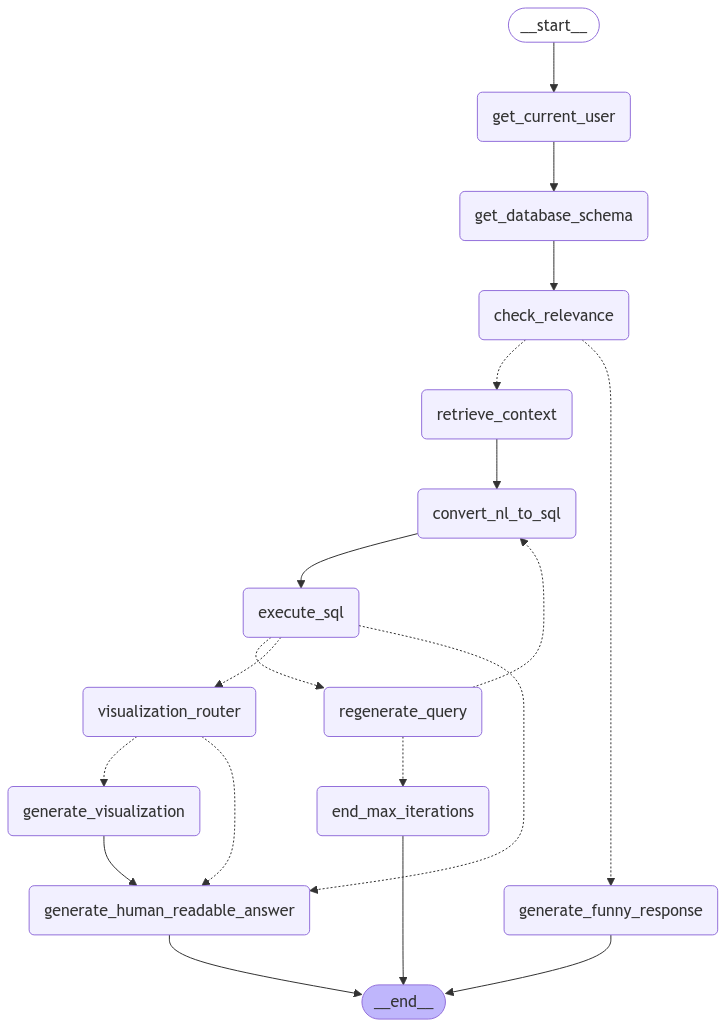

In [64]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [35]:
# # save the graph
# save_path = "workflow_graph.png"
# graph = app.get_graph(xray=True).draw_mermaid_png()
# with open(save_path, "wb") as f:
#     f.write(graph)

In [58]:
fake_config = {"configurable": {"current_user_id": "5"},"recursion_limit": 50}

In [59]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(5)
orders

[{'order_id': 8, 'food_name': 'Street_229709', 'price': 1000.07},
 {'order_id': 54, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 55, 'food_name': 'Spaghetti Carbonara', 'price': 41.81}]

In [39]:
user_question_2 = "Tell me about most expensive food all over the world."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food-related system, encompassing recipes, food items, and associated user interactions. The 'recipes' table, with its 6 columns, likely stores detailed information about various recipes, including ingredients and preparation instructions. The 'ingredients' table, containing 3 columns, is probably linked to the 'recipes' table to specify the components required for each recipe. The 'food' table, with 3 columns, and the 'food_category' table, with 2 columns, are likely used to categorize and manage different food items, with the 'food_category_mapping' table (5 columns) serving as a bridge to associate food items with their respective categories.

The 'reviews' table, which has 7 columns, is likely used to capture user feedback and ratings on recipes or food items, providing insights into user preferences and satisfa

In [60]:
user_question_3 = "Show me all coupons, with their discount values and expiry dates."
result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Retrieving database schema...
[DEBUG] Generated database description: The database is designed to manage user interactions and transactions within a system that likely involves food-related services or products. The 'users' table is central, storing essential user information, which is linked to the 'user_activity' table that tracks user actions and engagement. Financial transactions are managed through the 'payments' table, which records payment details, and is complemented by the 'discounts' and 'coupons' tables that store information on available discounts and promotional codes users can apply. The 'promotions' table extends this by detailing various promotional campaigns, possibly linking to both users and transactions. Additionally, the 'ingredients' and 'food_category' tables suggest a focus on food items, categorizing them and detailing their components, which could be used for inventory or

KeyError: 'query_result'

In [14]:
user_question_1 = '''Show me top 5 most cheap food name from database and their prices'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food-related system, encompassing recipes, payments, promotions, and customer feedback. The 'recipes' table, with its 6 columns, likely stores detailed information about various recipes, including ingredients and preparation instructions. The 'ingredients' table, containing 3 columns, is probably linked to the 'recipes' table to specify the components required for each recipe. The 'food' and 'food_category' tables, with 3 and 2 columns respectively, categorize different food items, and the 'food_category_mapping' table with 5 columns likely maps food items to their respective categories.

The 'payments' table, consisting of 5 columns, manages financial transactions, possibly related to purchasing food items or services. Promotions and discounts are handled through the 'promotions', 'coupons', and 'discounts' tables,

In [82]:
user_question_1 = '''Show me top 5 users who has highest points, and use a bar chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food service and hospitality system, encompassing user interactions, food management, and business operations. The 'users' table stores essential user information, which is linked to 'user_activity' to track user interactions and 'payments' to manage financial transactions. The 'food_category' and 'food_category_mapping' tables organize and associate food items with their respective categories, while the 'ingredients' table details the components of each food item. 

The 'promotions' table is used to manage marketing campaigns and special offers, potentially influencing user activity and reservations. The 'vendors' and 'suppliers' tables are crucial for managing business relationships and inventory, ensuring a steady supply of ingredients and other necessary items. The 'loyalty_program' table tracks user engagement 

In [42]:
user_question_1 = '''Show me average Salary by position'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage various aspects of a business, likely in the food service or retail industry. The 'employees' table stores information about the staff, which is essential for managing human resources. The 'payments' table likely tracks financial transactions, possibly related to customer purchases or employee salaries. The 'schedules' table is used to organize work shifts or appointments, ensuring efficient time management.

The 'coupons' and 'loyalty_program' tables are geared towards customer engagement, with the former managing discount offers and the latter tracking customer rewards and incentives. The 'reviews' table collects customer feedback, which can be crucial for service improvement and quality assurance. The 'food' and 'ingredients' tables are central to inventory management, detailing the products offered and their components, while t

KeyError: 'retrieve_context'

In [15]:
user_question_1 = '''Show percentage of each food category sold, use a pie chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a comprehensive food service system, encompassing various aspects of recipes, orders, payments, promotions, and user interactions. The 'recipes' table, with its 6 columns, likely stores detailed information about different food recipes, which could be linked to the 'food' table containing 3 columns, possibly detailing the ingredients or types of food available. The 'orders' and 'payments' tables, each with 5 columns, are crucial for tracking customer purchases and their corresponding payment transactions, ensuring smooth order processing and financial management.

Promotional activities are managed through the 'promotions' and 'coupons' tables, with 6 and 4 columns respectively, which might store data on active promotions and discount coupons available to customers. Customer feedback and experiences are captured in the 'reviews' ta

In [75]:
user_question_1 = ''' Analyze food's discount percentage, and show it in a pie chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage a food-related business, encompassing various aspects such as inventory, sales, and customer interactions. The 'food' table likely stores information about the food items available, while the 'food_category' and 'food_category_mapping' tables categorize these items, facilitating organization and retrieval. The 'ingredients' table probably details the components of each food item, which could be linked to the 'suppliers' table that manages information about ingredient providers. 

Customer interactions and sales are captured through the 'user_activity', 'payments', and 'promotions' tables, which track user engagement, financial transactions, and promotional offers, respectively. The 'reviews' table collects customer feedback, which can be crucial for improving service and product offerings. The 'vendors' table might contain informat

In [41]:
user_question_1 = ''' Show a scatter plot of price vs. discount percentage for food items..'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: The database is designed to manage various aspects of a restaurant or food service business. The 'employees' table likely stores information about staff members, which is essential for managing human resources. The 'recipes' table, with its 6 columns, probably contains detailed information about the dishes offered, including ingredients and preparation instructions. The 'payments', 'discounts', 'coupons', and 'promotions' tables collectively handle financial transactions and marketing strategies, ensuring efficient billing and customer engagement through special offers.

The 'reviews' table, with 7 columns, is crucial for capturing customer feedback, which can be used to improve service and food quality. The 'reservations' table manages booking details, facilitating efficient table management and customer service. The 'vendors' table, with 3 columns, likely tracks s

KeyError: 'retrieve_context'

In [92]:
user_question_1 = ''' Show me every silver user names and their points.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Generated database description: This database is designed to manage a comprehensive system for a restaurant or food service business. The 'users' table stores information about customers, likely including details such as user IDs and contact information. The 'orders' table tracks customer orders, potentially linking to the 'users' table to associate orders with specific customers. The 'ingredients' and 'suppliers' tables are likely used to manage inventory and procurement, ensuring the restaurant has the necessary supplies for menu items. The 'payments' table records financial transactions related to orders, while the 'loyalty_program' table manages customer rewards and incentives. The 'reservations' table handles booking information, and the 'reviews' table collects customer feedback, which can be linked back to the 'users' table. Lastly, the 'employees' table contains staff information, which ma